# Calculate HIA

This notebook caclulates Health Impact Assesments on Kearney, Nebraska, using estimates of average annual PM2.5 pollution.  It also explores sensitivity of the analysis to calculating HIA estimates based on average annual pollution, rather than daily polution. Finally, it creates a graph comparing premature mortality from fire pollution to other causes of premature mortality. 

# License 
This code was developed by Susan Boyd for use in HW1 assigned in DATA 512, a course in the UW MS Data Science degree program. This code is provided under an MIT license.

# Chat GPT Attribution
Selected functions or codeblocks in this Notebook were created with assistance from Chat GPT (https://chat.openai.com/). For any function or codeblock that was created with assistance from Chat GPT, the impacted code is isolated in a function or procedure and the use of Chat GPT is noted. Information on the prompts used to query Chat GPT isprovided at the end of the file. 


# Step 0 - Set Up Notebook 

In [1]:
# import needed libraries

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import forestplot as fp

# Step: 1 Load Data 

Load and Examine Smoke Impact Estimates 2006-2008 Based on ODell Data

In [2]:
f = "Data\Annual Summary PM25 Data ODell.csv"
impact_df = pd.read_csv(f)
impact_df["Tot. Impact"] = impact_df["Diff in Mean PM25"]*impact_df["Num Smoke Days"]
impact_df["Ave. Impact Per Day"] = impact_df["Tot. Impact"]/365 
impact_df.head()


,Year,Mean PM25 Smoke Days,Mean PM25 Non-Smoke Days,Diff in Mean PM25,Num Smoke Days,Avg. Annual Delta_PM25,Annual Mean Combined,Tot. Impact,Ave. Impact Per Day
0,2006,9.962489,9.129669,0.832820,25.0,0.057042,9.186712,20.820488,0.057042
1,2007,11.532424,10.237317,1.295107,30.0,0.106447,10.343764,38.853217,0.106447
2,2008,13.020036,10.141664,2.878372,40.0,0.315438,10.456240,115.134885,0.315438
3,2009,8.738054,7.630536,1.107518,18.0,0.054617,7.685154,19.935323,0.054617
4,2010,6.578359,7.080457,-0.502098,17.0,-0.023385,7.057071,-8.535658,-0.023385


In [3]:
# Sanity check my average delta PM25 over the time period 2006-2018
ave = impact_df["Ave. Impact Per Day"].mean()  
round(ave, 2)


0.28

Delta_PM25 values look reasonable.  O'Dell et. al. found that the mean smoke related PM25 for Nebraska for 2006-2018 was between 0.14 and .41 (depending on which part of Nebraska) so my average of .28 is reasonable.  See O'Dell p. 6, Map in Figure 1(a). 

Now load US population data 

In [4]:
f = "Data/us_pop_2000_2020.csv"
US_pop = pd.read_csv(f)
US_pop.head()

,Year,US POP
0,2000,282162411
1,2001,284968955
2,2002,287625193
3,2003,290107933
4,2004,292805298


Now load Kearney Population

In [5]:
f = "Data/Kearney_Pop.csv"
Kearney_pop =pd.read_csv(f)
Kearney_pop.head()

,Year,Pop
0,2000,27431
1,2001,27749
2,2002,28072
3,2003,28397
4,2004,28727


Now load and display the HIA contants

In [6]:
f = "Data/HIA_Constants_Raw/HIA_Constants.xlsx"
HIA_CONSTANTS =pd.read_excel(f)
HIA_CONSTANTS.head()

,Event,Baseline,OR,OR_LOWER,OR_UPPER
0,ER,0.006257,1.07,1.03,1.11
1,Admit,0.001299,1.08,1.03,1.14
2,Mortality,0.007329,1.06,1.04,1.08


Also load the daily PM2.5 data, which we'll use for sensitivity analysis

In [7]:
# Daily data 
f = "Data\Odell_Smoke.csv"
daily_pm25 = pd.read_csv(f)
daily_pm25["Daily_Smoke_Diff"]=(daily_pm25["PM25"]-daily_pm25["Background_PM25"])*daily_pm25["HMS_Smoke"]
#daily_pm25.head()

# Step 2: Set some constants for use in the calculations below

In [8]:
# Population Statistics 
#US
US_POP_2009 = float(US_pop[US_pop["Year"]==2009]["US POP"])
US_POP_2018 = float(US_pop[US_pop["Year"]==2018]["US POP"])
US_POP_2020 = float(US_pop[US_pop["Year"]==2020]["US POP"])

KEARNY_POP_2020 = 33867  
NEBRASKA_POP_2020 =  1961504

K_US_RATIO = KEARNY_POP_2020/US_POP_2020
#print(round(K_US_RATIO*1000, 2))


# Set_Betas From OR 
col = HIA_CONSTANTS["OR"] 
HIA_CONSTANTS["Beta"] = np.log(col)/10
col = HIA_CONSTANTS["OR_LOWER"] 
HIA_CONSTANTS["Beta_CI_Lower"] =  np.log(col)/10
col = HIA_CONSTANTS["OR_UPPER"] 
HIA_CONSTANTS["Beta_CI_Upper"] =  np.log(col)/10

# Step 3 Define HIA Functions - Annual Calc Method  

In [9]:
# Functions to calculate increased ER visist, hospital admissions, or mortality from fire pollution  
# GENERAL FORM OF EQUATION = Population*(Baseline)*(1-exp(-ϐ*ΔPM2.5)
# ATTRIBUTION NOTE: Methods and code adapated from O'Dell et. al., 2019 

def calc_annual_impact(pop, event, delta_PM25, take_max = False):
    if take_max:
        delta_PM25 = max(0, delta_PM25)
    baseline = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Baseline"]
    beta = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta"]
    outcome = float(pop*baseline*(1-np.exp(-beta*delta_PM25)))
    beta_CI_low = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta_CI_Lower"]
    outcome_CI_low = float(pop*baseline*(1-np.exp(-beta_CI_low*delta_PM25)))
    beta_CI_high = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta_CI_Upper"]
    outcome_CI_high = float(pop*baseline*(1-np.exp(-beta_CI_high*delta_PM25)))
    return (outcome, outcome_CI_low, outcome_CI_high)

In [10]:
# Sanity Check 
# Does my function replicate (in the ballpark) of the findings for all US 
# from O'Dell and Ford papers 

# All-US Delta_PM
delta_PM25_US_2018  = .73 # 2018 pop-weighted mean annual fire related PM2.5, highest year (O'Dell p.6)
delta_PM25_US_2009 = .11 # 2009 pop-weighted mean annual fire related PM2.5, lowest year (O'Dell p.6)

# US ED_Visits Caused by smoke pollution 
er_2018 = calc_annual_impact(US_POP_2018, "ER", delta_PM25_US_2018)[0]
er_2009 = calc_annual_impact(US_POP_2009, "ER", delta_PM25_US_2009)[0]
admit_2018 = calc_annual_impact(US_POP_2018, "Admit", delta_PM25_US_2018)[0]
admit_2009 = calc_annual_impact(US_POP_2009, "Admit", delta_PM25_US_2009)[0]
mortality_2018 = calc_annual_impact(US_POP_2018, "Mortality", delta_PM25_US_2018)[0]
mortality_2009 = calc_annual_impact(US_POP_2009, "Mortality", delta_PM25_US_2009)[0]

print(f"ER Range_{round(er_2009)}_to_{round(er_2018)}")
print(f"Admit Range_{round(admit_2009)}_to_{round(admit_2018)}")
print(f"Mortality Range_{round(mortality_2009)}_to_{round(mortality_2018)}")
                                    

ER Range_1428_to_10076
Admit Range_337_to_2379
Mortality Range_1441_to_10168


ER and Admit
Lowends for ER and Admit closely match O'Dell et al. findings (Table 1, p.8) but I get higher values for high end of range by factor of 1.5-2.  Possibly because I simplified to annual and response function is non-linear - however, as explained below, this should have a small impact for the range of data relevant in my study. Other possible explanations include (1) differences in population estimates used, and (2) that O'Dell calculated response for each 15x15 cell and not using a US average as I did above. Overall, my estimates appear generally in range with the O'Dell findings, although the potential for overestimating at the upper bounds should be noted.  

Mortality 
Ford et.al. found mortality in the range of 7K - 28K for 2000, notably higher than my range of 1.4K to 10K, especially on the low end.  Ford et al. used simulated,rather than observed PM25 data.  O'Dell et. al, used the same PM25 concentration data as I do, but a slightly different excess mortality estimator.  They reported results in the range 4,800 - 7,800, similar to my range but narrower.  
 

In [11]:
# examine midpoint of my range for mortalit vs. midpoint of O'Dell Range 
# And 5 diff 
my_mort_mid = (1441+10168)/2
ODell_mort_mid = (4800+7800)/2
diff = (my_mort_mid-ODell_mort_mid)/my_mort_mid
print(my_mort_mid, ODell_mort_mid, diff )

5804.5 6300.0 -0.08536480316995435


In [12]:
# Let's also look at the 95% CI for the high and low years 

print("ER")
er_2018, er_2018_CI_low, er_2018_CI_high = calc_annual_impact(US_POP_2020, "ER", delta_PM25_US_2018)
print(er_2018, er_2018_CI_low, er_2018_CI_high)
er_2009, er_2009_CI_low, er_2009_CI_high = calc_annual_impact(US_POP_2009, "ER", delta_PM25_US_2009)
print(er_2009, er_2009_CI_low, er_2009_CI_high)
print("")


print("Mortality")
mortality_2018, mortality_2018_CI_low, mortality_2018_CI_high = calc_annual_impact(US_POP_2020, "Mortality", delta_PM25_US_2018)
print(mortality_2018, mortality_2018_CI_low, mortality_2018_CI_high)
mortality_2009, mortality_2009_CI_low, mortality_2009_CI_high = calc_annual_impact(US_POP_2009, "Mortality", delta_PM25_US_2009)
print(mortality_2009, mortality_2009_CI_low, mortality_2009_CI_high)



ER
10157.217652178428 4443.670665083336 15646.038792692547
1428.0243356899969 624.0079463557554 2202.2102147159635

Mortality
10250.22488891471 6904.206432550708 13529.177316209321
1440.6813687493443 969.8220202295549 1902.643190315991


# Step 4: Examine Shape of HIA Functions

In [13]:
# Largest Beta * delta_PM25 in my range of data 

# Largest Beta 
largest_B =  max(HIA_CONSTANTS["Beta_CI_Upper"])
largest_delta_PM25 = .73
largest = largest_B


In [14]:
# largest PM2.5 reading if we looked at it on a daily basis 
largest_daily_pm25 = round(max(daily_pm25["PM25"]))
largest_daily_pm25


35

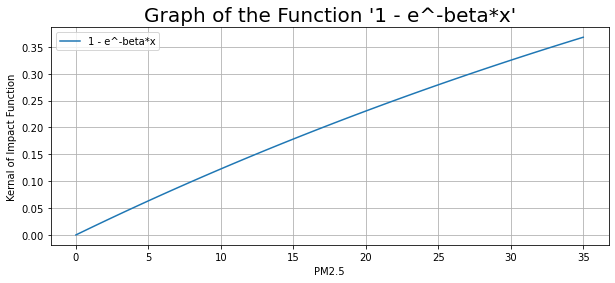

In [15]:
# When B*delta_PM25 is small, response function is mostly linear 
# Let's see how it looks with our largest combo of B*delta_PM25

# Define the function
def my_function(x):
    return (1 - np.exp(-largest*x))

# Generate x values from 0 to largest_daily_pm25 with a certain step size
x_values = np.linspace(0, largest_daily_pm25, 100)

# Calculate corresponding y values using the function
y_values = my_function(x_values)

# Plot the function
plt.figure(figsize=(10, 4))
plt.plot(x_values, y_values, label= "1 - e^-beta*x")
plt.xlabel('PM2.5')
plt.ylabel('Kernal of Impact Function')
plt.legend()
plt.grid(True)


# Save the plot as a JPG file
f_out = "Visuals/Figure A1.jpg"
plt.savefig(f_out)
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)

# Add title and display 
t = "Graph of the Function '1 - e^-beta*x'"
plt.title(t, fontsize = 20) 
plt.show(); 




In the relevant ranges in the dataset, treating the response function as approximately linear is a reasonable simplification. 

In [16]:
# Compare to when B is large 

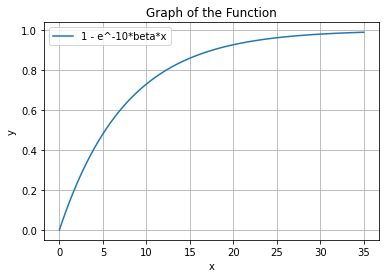

In [17]:
# Define the function
def my_function(x):
    return (1 - np.exp(-10*largest*x))

# Generate x values from 0 to 2 with a certain step size
x_values = np.linspace(0, largest_daily_pm25, 100)

# Calculate corresponding y values using the function
y_values = my_function(x_values)

# Plot the function
plt.plot(x_values, y_values, label= "1 - e^-10*beta*x")
plt.title("Graph of the Function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

When Beta*Delta_PM is higher, the response function becomes increasingly concave. In this case, assuming that increased PM2.5 levels are evenly distributed accross the year will tend to OVER predict impact (several small increases contribute more than one large increase). But the above graph uses a significantly higher value of beta than is relevant to my dataset.  

# Step 5: Calculate Historical Health Impact on Kearny from Fire Related PM25  

In [18]:
# given a df with two columns "Year" and "Delta_PM25"
# return a dataframe with estimate and upper and lower CI for 
# mortality, ER visits, and Hospital Admits 


def calc_HIA_all_yrs(df):

    yrs = df["Year"]

    ER_record =[]
    ER_CI_lower_record = []
    ER_CI_upper_record = []
    Admit_record=[]
    Admit_CI_lower_record = []
    Admit_CI_upper_record = []
    Mortality_record=[] 
    Mortality_CI_lower_record = []
    Mortality_CI_upper_record = []

    for year in yrs: 
        delta_pm25 = float(df[df["Year"] == year]["Ave. Impact Per Day"])
        pop = int(Kearney_pop[Kearney_pop["Year"]==year]["Pop"])
        ER, ER_CI_lower, ER_CI_upper = calc_annual_impact(pop, "ER", delta_pm25)
        ER_record.append(ER)
        ER_CI_lower_record.append(ER_CI_lower)
        ER_CI_upper_record.append(ER_CI_upper)
    
        Admit, Admit_CI_lower, Admit_CI_upper = calc_annual_impact(pop, "Admit", delta_pm25)
        Admit_record.append(Admit)
        Admit_CI_lower_record.append(Admit_CI_lower)
        Admit_CI_upper_record.append(Admit_CI_upper)
    
    
        Mortality, Mortality_CI_lower, Mortality_CI_upper = calc_annual_impact(pop, "Mortality", delta_pm25)
        Mortality_record.append(Mortality)
        Mortality_CI_lower_record.append(Mortality_CI_lower)
        Mortality_CI_upper_record.append(Mortality_CI_upper)
      


    summary_impacts = pd.DataFrame ({
        'Year': yrs,
        'Excess Asthma ER Visits': ER_record,
        'ER Visits CI Lower': ER_CI_lower_record,
        "ER Visits CI Upper": ER_CI_upper_record,
        "Excess Asthma Hospital Admits": Admit_record,
        "Hospital CI Lower": Admit_CI_lower_record,
        "Hospital CI Upper": Admit_CI_upper_record,
        "Excess Mortality": Mortality_record,
        "Mortality CI Lower": Mortality_CI_lower_record,
        "Mortality CI Upper": Mortality_CI_upper_record,
    })

    return(summary_impacts)
    

In [19]:
historical_impacts = calc_HIA_all_yrs(impact_df)
historical_impacts.head()

,Year,Excess Asthma ER Visits,ER Visits CI Lower,ER Visits CI Upper,Excess Asthma Hospital Admits,Hospital CI Lower,Hospital CI Upper,Excess Mortality,Mortality CI Lower,Mortality CI Upper
0,2006,0.070978,0.031012,0.109468,0.016761,0.006438,0.028532,0.071605,0.048200,0.094570
1,2007,0.133966,0.058539,0.206595,0.031635,0.012153,0.053843,0.135153,0.090980,0.178491
2,2008,0.401306,0.175429,0.618636,0.094755,0.036420,0.161186,0.404902,0.272621,0.534633
3,2009,0.070356,0.030740,0.108509,0.016614,0.006382,0.028282,0.070977,0.047777,0.093741
4,2010,-0.030481,-0.013316,-0.047018,-0.007198,-0.002765,-0.012256,-0.030750,-0.020697,-0.040615


In [20]:
# save historical results dataframe to file 
f_out = 'Data/historical_impacts.csv'
historical_impacts.to_csv(f_out, index = False)

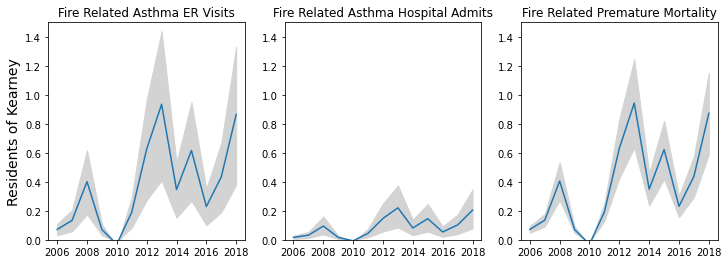

In [21]:
# Graph the annual impact results of each event, with CI 



# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize = (12,4))

#shorter name for the df for convenience 
df = historical_impacts

# Set the titles for each of the three graphs 
t1 = "Fire Related Asthma ER Visits"
t2 = "Fire Related Asthma Hospital Admits"
t3 = "Fire Related Premature Mortality"
titles = [t1, t2, t3]
events = ["Excess Asthma ER Visits", "Excess Asthma Hospital Admits", "Excess Mortality"]
events_lower = ["ER Visits CI Lower", "Hospital CI Lower", "Mortality CI Lower"]
events_upper = ["ER Visits CI Upper", "Hospital CI Upper", "Mortality CI Upper"]


for i in range(3): 
    event = events[i]
    event_lower = events_lower[i] 
    event_upper = events_upper[i]
    ax = axes[i]
    t = titles[i]
    x = df["Year"]
    y = df[event]
    ax.plot(x, y)
    ax.fill_between(df["Year"], df[event_lower], df[event_upper], \
                     color='lightgray', label='95% Confidence Interval')
    ax.set_title(t, fontsize = 12)
    ax.set_ylim(0, 1.5)
    ax.set_xticks([2006, 2008, 2010, 2012, 2014, 2016, 2018])
    if i == 0:
        ax.set_ylabel("Residents of Kearney", fontsize = 14)
     

# Save the plot as a JPG file
f_out = "Visuals/Figure 8.jpg"
plt.savefig(f_out)
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)

#Display 
plt.show(); 

    




In [22]:
# Mortality Cumulative
tot_excess_mortality = sum(historical_impacts["Excess Mortality"])
tot_excess_mortality_CI_lower = sum(historical_impacts["Mortality CI Lower"])
tot_excess_mortality_CI_upper = sum(historical_impacts["Mortality CI Upper"])


tot_mort_estimates = [tot_excess_mortality_CI_lower, tot_excess_mortality, tot_excess_mortality_CI_upper]
rounded_list = [round(element, 2) for element in tot_mort_estimates]
print(rounded_list)


[3.32, 4.93, 6.51]


In [23]:
# ER Visits Cumulative

tot_excess_ER = sum(historical_impacts["Excess Asthma ER Visits"])
tot_excess_ER_CI_lower = sum(historical_impacts["ER Visits CI Lower"])
tot_excess_ER_CI_upper = sum(historical_impacts["ER Visits CI Upper"])


tot_ER_estimates = [tot_excess_ER_CI_lower, tot_excess_ER, tot_excess_ER_CI_upper]
rounded_list = [round(element, 2) for element in tot_ER_estimates]
print(rounded_list)

[2.14, 4.89, 7.53]


In [24]:
# Hospital Admits Cumulative

tot_excess_Admits = sum(historical_impacts["Excess Asthma Hospital Admits"])
tot_excess_Admits_CI_lower = sum(historical_impacts["Hospital CI Lower"])
tot_excess_Admits_CI_upper = sum(historical_impacts["Hospital CI Upper"])


tot_Admits_estimates = [tot_excess_Admits_CI_lower, tot_excess_Admits, tot_excess_Admits_CI_upper]
rounded_list = [round(element, 2) for element in tot_Admits_estimates]
print(rounded_list)

[0.44, 1.15, 1.96]


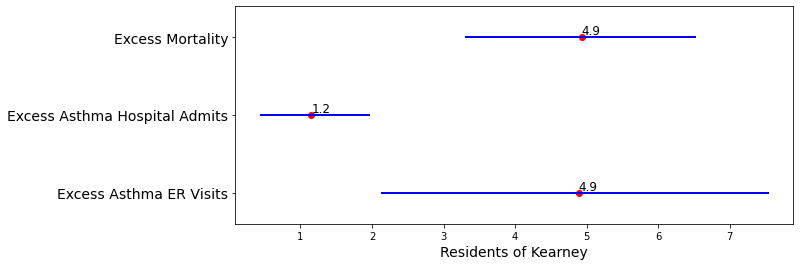

In [25]:
# Graph Results
# See Chat GPT Attribution at end of Notebook 


labs = ["Excess Asthma ER Visits", 
        "Excess Asthma Hospital Admits",
        "Excess Mortality"] 


df = pd.DataFrame()
df["Labels"] = labs
df["Estimates"] = [tot_excess_ER, tot_excess_Admits, tot_excess_mortality] 
df["Lower CI"] = [tot_excess_ER_CI_lower, tot_excess_Admits_CI_lower, tot_excess_mortality_CI_lower] 
df["Upper CI"] = [tot_excess_ER_CI_upper, tot_excess_Admits_CI_upper, tot_excess_mortality_CI_upper] 


# Plotting
fig, ax = plt.subplots(figsize=(10, 4))
#plt.subplots_adjust(top=0.8, bottom=0.2)


for i, label in enumerate(df["Labels"]):
    ax.scatter(df.loc[i, "Estimates"], label, color='red', marker='o', label=f'Estimate {label}')
    ax.text(df.loc[i, "Estimates"], label, f'{df.loc[i, "Estimates"]:.1f}', ha='left', va='bottom', color='black', fontsize=12)
    
# Plot confidence interval as horizontal lines
for i, label in enumerate(df["Labels"]):
    ax.plot([df.loc[i, "Lower CI"], df.loc[i, "Upper CI"]], [label, label], color='blue', \
            linestyle='-', linewidth=2, label=f'CI {label}')

    
# Customize the plot
ax.set_xlabel("Residents of Kearney", fontsize = 14)
#ax.set_title("Cumulative Health Impact Estimates Due to Fire Pollution (2006-2018)", fontsize =16)
#ax.set_suptitle("(Estimates in Red, 95% Confidence Intervals in Blue)", y=0.9, fontsize=14)
ax.set_yticks(df["Labels"])
ax.set_yticklabels(df["Labels"], fontsize=14)
ax.margins(y=0.2)  # Set vertical margin


# Save the plot as a JPG file
f_out = "Visuals/Figure 9.jpg"
plt.savefig(f_out)
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)

#Display 
plt.show(); 



# Step 6 - Sensitivity Analysis (Daily versus Annual Calculation Methods)

Define a function that calculates impacts based on daily changes in Delta PM2.5

In [26]:
# daily impact function that takes as inputs population, event, and DAILY change in PM25
# and returns a tuple with the estimated health impact, lower value of the CI range, and upper value 
def calc_daily_impact(pop, event, delta_PM25):
    baseline = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Baseline"]/365
    beta = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta"]
    outcome = float(pop*baseline*(1-np.exp(-beta*delta_PM25)))
    beta_CI_low = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta_CI_Lower"]
    outcome_CI_low = float(pop*baseline*(1-np.exp(-beta_CI_low*delta_PM25)))
    beta_CI_high = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta_CI_Upper"]
    outcome_CI_high = float(pop*baseline*(1-np.exp(-beta_CI_high*delta_PM25)))
    return (outcome, outcome_CI_low, outcome_CI_high)

Now a function to calculate Annual impact by summing over daily values rather than using annual average 

In [27]:
def calc_annual_smoke_impact_daily_method(pop, event, delta_smoke, take_max = False):
    tot_outcome = 0 
    for delta_smoke_day in delta_smoke:
        if take_max:
            delta_smoke_day = max(0, delta_smoke_day)
        outcome = calc_daily_impact(pop, event, delta_smoke_day)[0]
        tot_outcome += outcome
    return tot_outcome 

Look at how mortality estimates differ for a specific year using the two methods 

In [28]:
# Doing it the old way, annual method
year  = 2018
df =impact_df
delta_pm25 = float(df[df["Year"] == year]["Ave. Impact Per Day"])
pop = int(Kearney_pop[Kearney_pop["Year"]==year]["Pop"])
Mortality, Mortality_CI_lower, Mortality_CI_upper = calc_annual_impact(pop, "Mortality", delta_pm25)
print(f"Using the average annaul method, estiamted mortality for_{year} is")
print(Mortality, Mortality_CI_lower, Mortality_CI_upper)        

Using the average annaul method, estiamted mortality for_2018 is
0.8727037221283382 0.5877607837524431 1.1519948280169436


In [29]:
# Now using daily method 
year = 2018
df = daily_pm25
delta_pm25=(df[df["Year"] == year]["Daily_Smoke_Diff"])
pop = int(Kearney_pop[Kearney_pop["Year"]==year]["Pop"])
Mortality_daily = calc_annual_smoke_impact_daily_method(pop, "Mortality", delta_pm25)
print(Mortality_daily)

0.8994833412331412


Results look close via two methods for 2018, now lets look at all year 

In [30]:
# Calcl results all years using daily method 
Years = df["Year"].drop_duplicates().tolist()
Years_record = []
Mortality_daily_meth_record =[]

for yr in Years:
    delta_pm25=(df[df["Year"] == yr]["Daily_Smoke_Diff"])
    pop = int(Kearney_pop[Kearney_pop["Year"]==year]["Pop"])
    Mortality_daily = calc_annual_smoke_impact_daily_method(pop, "Mortality", delta_pm25, take_max = False)
    Years_record.append(yr)
    Mortality_daily_meth_record.append(Mortality_daily)

results_daily_method = pd.DataFrame({
    "Year": Years_record,
    "Mortality_daily_method": Mortality_daily_meth_record 
})    
    
# display results alongside annual to compare
results_daily_method["Compare: Ann. Method"] = historical_impacts["Excess Mortality"]
results_daily_method["Overstate_Factor"] = results_daily_method["Compare: Ann. Method"]/results_daily_method["Mortality_daily_method"]  
results_daily_method.head()
    

,Year,Mortality_daily_method,Compare: Ann. Method,Overstate_Factor
0,2006,-0.012454,0.071605,-5.749712
1,2007,0.083653,0.135153,1.615640
2,2008,0.213891,0.404902,1.893027
3,2009,0.056313,0.070977,1.260411
4,2010,0.040325,-0.030750,-0.762555


In [31]:
# Calcl results all years using daily method 
# But now treat any negative daily values as zero 
Years = df["Year"].drop_duplicates().tolist()
Years_record = []
Mortality_daily_drop_neg_record =[]

for yr in Years:
    delta_pm25=(df[df["Year"] == yr]["Daily_Smoke_Diff"])
    pop = int(Kearney_pop[Kearney_pop["Year"]==year]["Pop"])
    Mortality_daily = calc_annual_smoke_impact_daily_method(pop, "Mortality", delta_pm25, take_max = True)
    Years_record.append(yr)
    Mortality_daily_drop_neg_record.append(Mortality_daily)

results_daily_method["Mortality_daily_drop"] = Mortality_daily_drop_neg_record
results_daily_method["Overstate_Factor Drop"] = results_daily_method["Compare: Ann. Method"]/results_daily_method["Mortality_daily_drop"]  

# display results 
results_daily_method

,Year,Mortality_daily_method,Compare: Ann. Method,Overstate_Factor,Mortality_daily_drop,Overstate_Factor Drop
0,2006,-0.012454,0.071605,-5.749712,0.114664,0.624478
1,2007,0.083653,0.135153,1.615640,0.210179,0.643038
2,2008,0.213891,0.404902,1.893027,0.383751,1.055116
3,2009,0.056313,0.070977,1.260411,0.131075,0.541501
4,2010,0.040325,-0.030750,-0.762555,0.066282,-0.463920
5,2011,0.278866,0.192396,0.689924,0.337340,0.570332
6,2012,0.627103,0.630874,1.006013,0.819270,0.770043
7,2013,0.795394,0.943356,1.186023,0.870730,1.083408
8,2014,0.274772,0.349324,1.271324,0.338056,1.033332
9,2015,0.495021,0.621869,1.256248,0.605349,1.027291


Most years within a factor of 2, with anomoly in 2006 and 2010 likely becasue negative numbers are a bit hard to interpret 

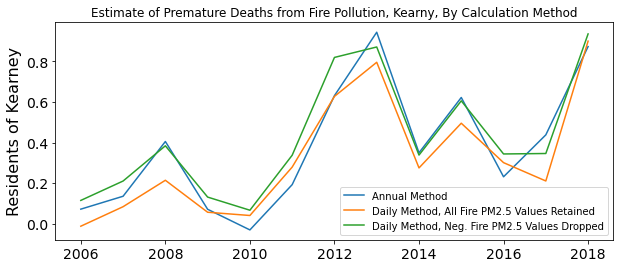

In [32]:
# graph results 
df = results_daily_method
x = df["Year"]
y1  = df["Compare: Ann. Method"]
y2 = df["Mortality_daily_method"]
y3 = df["Mortality_daily_drop"]

plt.figure(figsize=(10, 4))
plt.plot(x, y1, label = "Annual Method")
plt.plot(x, y2, label = "Daily Method, All Fire PM2.5 Values Retained")
plt.plot(x, y3, label = "Daily Method, Neg. Fire PM2.5 Values Dropped")
plt.ylabel("Residents of Kearney", fontsize = 16)
plt.legend(fontsize = 10)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)


# Save the plot as a JPG file
f_out = "Visuals/Figure A2.jpg"
plt.savefig(f_out)
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)

#Add Title and Display 
plt.title('Estimate of Premature Deaths from Fire Pollution, Kearny, By Calculation Method')
plt.show(); 




Now let's compare the cumulative for the period

In [33]:
daily_method_cum_estimate = sum(results_daily_method["Mortality_daily_method"])
daily_method_drop_cum_estimate = sum(results_daily_method["Mortality_daily_drop"])
annual_method_cum_estimate = sum(results_daily_method["Compare: Ann. Method"])


print(f"Using Daily method, cumulative mortality for period was_{daily_method_cum_estimate}")
print(f"Using Daily method, but treating neg. numbers as zero, cumulative mortality for period was_{daily_method_drop_cum_estimate}")
print(f"Using Annual method, cumulative mortality for period was_{annual_method_cum_estimate}")


Using Daily method, cumulative mortality for period was_4.263575904060747
Using Daily method, but treating neg. numbers as zero, cumulative mortality for period was_5.501108153983309
Using Annual method, cumulative mortality for period was_4.931125500438532


In [34]:
# percent diff daily_method to annual 
daily_method_cum_estimate/annual_method_cum_estimate - 1

-0.13537469211003028

In [35]:
# percent diff daily_method_drop to annual 
daily_method_drop_cum_estimate/annual_method_cum_estimate -1

0.1155887542294527

# Step 7 Mortality Estimates In Context (Using Annual Methods)

Load in Dataframe of cumulative mortality 2006-2018 from other causes 

In [36]:
f = "Data/Other_Cause_Mortality.csv"
other_mort = pd.read_csv(f)
other_mort

,Cause,Deaths
0,Fire Arms,35.727921
1,Traffic Fatalities,49.905394
2,Heart Disease,763.791978
3,Homocide,12.675315


In [37]:
# Add the smoke pollution to the mortality dataframe 

new_row = pd.DataFrame({
    'Cause': ["Smoke Pollution"],
    "Deaths": [tot_excess_mortality]
}, index=[4])

all_mort = pd.concat([other_mort, new_row], axis=0)
all_mort 


,Cause,Deaths
0,Fire Arms,35.727921
1,Traffic Fatalities,49.905394
2,Heart Disease,763.791978
3,Homocide,12.675315
4,Smoke Pollution,4.931126


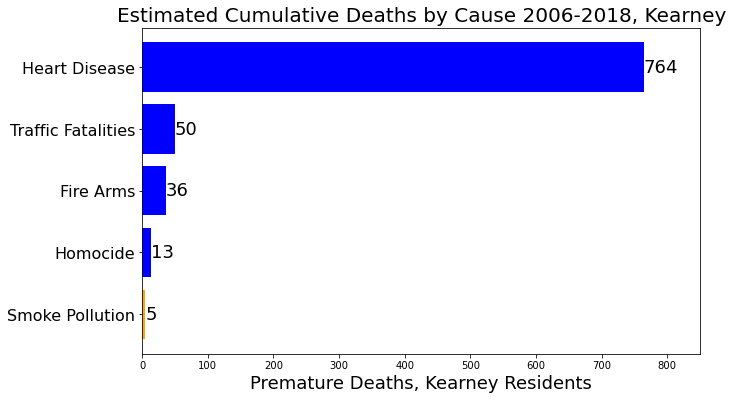

In [38]:
# graph mortalities in a bar graph 
# Please see chat GPT attribution note at end of notebook 



all_mort_sorted = all_mort.sort_values(by='Deaths', ascending=True)

# Set the color for each bar based on the 'Cause' column
colors = ['orange' if cause == 'Smoke Pollution' else 'blue' for cause in all_mort_sorted['Cause']]

# Create the horizontal bar graph
plt.figure(figsize=(10, 6))
plt.barh(all_mort_sorted['Cause'], all_mort_sorted['Deaths'], color=colors)

# Add labels with rounded deaths to the right of the bars
for i, value in enumerate(all_mort_sorted['Deaths']):
    plt.text(value, i, str(round(value)), va='center', fontsize = 18)

# Set labels and title
plt.xlabel('Premature Deaths, Kearney Residents', fontsize = 18)
plt.tick_params(axis='y', labelsize=16)

# Set x-axis limit to extend it to 850
plt.xlim(0, 850)



# Save the plot as a JPG file
f_out = "Visuals/Figure 10.jpg"
plt.savefig(f_out)
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)

#Add Title and Display 
plt.title('Estimated Cumulative Deaths by Cause 2006-2018, Kearney', fontsize = 20)
plt.show(); 







# CHAT GPT ATTRIBUTION 

The following function(s) or codeblock(s) contained in this notebook were written with assistance from Chat GPT available at: https://chat.openai.com/. In some cases, code suggested by Chat GPT was then further modified by the Notebook author, Sue Boyd.

***
For assistance writing the code block "# Graph Results", chat GPT was given the following prompts: 

"I have a dataframe with four columns: "Labels", "Estimates", "Lower CI" and "Upper CI".  For each value in "Labels" I want to graph the estimate as a point and the range of the confidence interval (from lower CI to upper CI) as a line.   Write this code"

AND

"Update the code to label each point estimate with its value, rounded to two decimal places"

AND

"Update the graph so that the bars or horizontal instead of vertical."

AND

"Keep it horizontal like that but instead of the estimate being a bar, keep it as a point."

AND

"Update the code so that the text labels appear below the scatter dots and confidence interval lines, not directly on them."

AND

"Move the data values closer together vertically and farther away from the bottom and top edges of the graph

***
For assistance in writing the code block "# graph mortalities in a bar graph", Chat GPT was given the following prompt: 

"I have a dataframe called "all_mort" with columns "Cause" containing text and "Deaths" containing a number.  Create a horizota bar graph of Deaths by cause in descening order.   Add labels with the deaths, rounded to the nearest whole number, to the right of the bars. Label the x axis "Premature Deaths, Kearney Residents".  Make the bars blue except that the bar for the cause called "Smoke Pollution" should be orange. Thanks."
